Diamond recognition

Intro 

My name is Ofir Giat(204623383), young computer science student who is passionate about data science. when i tried to come with idea for a project, i knew i need a real problem from my daily life that i can relate to. I manage to define many problems that would be nice to solve but it was actually very hard to find a way to solve them through deep learning, either the problems were too simple and were not worth the effort to solve them that way, or i couldn't find a satisfying data-set to work with. it was very frustrating. and then one day my wife started to ask me questions about the diamond ring that i bought her. and then i found my self explaining about its properties and how much it worth because of its features. and then I realized, that i don't actually know if it is like the things i say since you cant really see the differences without having the skills for it. then I had the Idea that it would be nice if i had an app that would tell me what are the features of the diamond based on a picture of it.

Why is it worth the effort?
Since I am not the only one who finds himself buying a diamond during his life and does not really have the ability to distinguish between the qualities of the diamond and is forced to rely on the credibility of the seller, such a tool can certainly improve the feeling of security during the purchase, and reduce the chance of buying a fake.

Domain knowledge

The prices of rough diamonds are determined according to the various sorting categories that relate to shape, size, color and cleanliness. The prices of the polished diamonds are also determined by the quality of the polishing.
The clarity level of the diamond, known in the commercial jargon as clarity, refers to the defects and inclusions of the diamond - inside it and on its surface. The clarity score of the diamond will be determined according to the type of inclusions or defects, their size, location, visibility, etc.
clarity scale in descending order:FL,IF,VVS1,VVS2,VS1,VS2,SI1,SI2,I1,I2,I3.
It is customary to divide diamonds into two main groups - normal colors and special colors (colored diamonds). Each group has its own rating scale.
The letter D indicates a completely colorless diamond. As you go up the grade of letters, the color of the diamond is more yellowish.
The colors of colored diamonds, or by their commercial name Fancy color diamonds, are measured in a completely different way when the most important criterion is the intensity of the color of the diamond.
Another index that affects the price of a diamond and its perceived quality is the diamond fluorescence index. Many diamonds emit a bluish light when placed under a UV lamp (which emits ultraviolet rays). For colorless diamonds, high fluorescence is considered to be what creates a frosty appearance and therefore cheapens them. For yellowish diamonds, high fluorescence is a positive thing because it whitens them.
fluorescence scale in descending order:NONE,Very Faint,Faint,Very Sligh,Slight,Medium,Strong,Very Strong.
A carat is a unit of weight of gemstones, and is exactly equal to 200 milligrams.
The carat is divided into 100 points, each weighing 2 milligrams.

A Bit About The Data

I found this data at kaggle.com/datasets/aayushpurswani/diamond-images-dataset.
The image data is scraped from https://capitalwholesalediamonds.com, featuring predominantly GIA-certified diamonds.
I tried to use tensorflow and keras at the begining, but found that pytorch gave me better results.

EDA

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
csv_file='diamond_data.csv'
root_dir='web_scraped'
dataframe = pd.read_csv(os.path.join(root_dir, csv_file))

In [3]:
# Check directory structure and load the labels
train_labels = os.listdir(root_dir)
print("Classes:", train_labels)

Classes: ['cushion', 'diamond_data.csv', 'emerald', 'heart', 'marquise', 'oval', 'pear', 'princess', 'round']


as we can see the data is divided to classes based on the images shapes and we have the diamond_data csv that contains all the details of the images.
lets take a look at the csv structure.

In [4]:
dataframe.head()

,path_to_img,stock_number,shape,carat,clarity,colour,cut,polish,symmetry,fluorescence,lab,length,width,depth
0,web_scraped/cushion/2106452.jpg,2106452,cushion,0.55,SI2,N,VG,EX,VG,N,GIA,4.56,4.44,3.09
1,web_scraped/cushion/2042329.jpg,2042329,cushion,0.52,SI2,Y-Z,EX,EX,VG,F,GIA,4.40,4.31,2.99
2,web_scraped/cushion/2055268.jpg,2055268,cushion,0.50,SI1,L,VG,EX,VG,N,GIA,4.87,4.19,2.89
3,web_scraped/cushion/2128779.jpg,2128779,cushion,0.50,VS2,M,EX,EX,VG,F,GIA,4.73,4.28,2.84
4,web_scraped/cushion/2103991.jpg,2103991,cushion,0.51,SI1,M,EX,EX,VG,N,GIA,4.47,4.44,3.05


the csv contains 13 features but the stock_number and the lab are defenatly irrelevant, lets discard them.

In [5]:
dataframe = dataframe.drop(columns=['stock_number', 'lab'])
dataframe.head()

,path_to_img,shape,carat,clarity,colour,cut,polish,symmetry,fluorescence,length,width,depth
0,web_scraped/cushion/2106452.jpg,cushion,0.55,SI2,N,VG,EX,VG,N,4.56,4.44,3.09
1,web_scraped/cushion/2042329.jpg,cushion,0.52,SI2,Y-Z,EX,EX,VG,F,4.40,4.31,2.99
2,web_scraped/cushion/2055268.jpg,cushion,0.50,SI1,L,VG,EX,VG,N,4.87,4.19,2.89
3,web_scraped/cushion/2128779.jpg,cushion,0.50,VS2,M,EX,EX,VG,F,4.73,4.28,2.84
4,web_scraped/cushion/2103991.jpg,cushion,0.51,SI1,M,EX,EX,VG,N,4.47,4.44,3.05


now we can take a dipper look at the data

In [6]:
print(dataframe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48764 entries, 0 to 48763
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   path_to_img   48764 non-null  object 
 1   shape         48764 non-null  object 
 2   carat         48764 non-null  float64
 3   clarity       48726 non-null  object 
 4   colour        48764 non-null  object 
 5   cut           47749 non-null  object 
 6   polish        48762 non-null  object 
 7   symmetry      48762 non-null  object 
 8   fluorescence  48764 non-null  object 
 9   length        48764 non-null  float64
 10  width         48764 non-null  float64
 11  depth         48764 non-null  float64
dtypes: float64(4), object(8)
memory usage: 4.5+ MB
None


there are 48764 images in the data but there are features that have null values.
lets see which one and how many they are.

In [7]:
print(dataframe.isnull().sum())

path_to_img        0
shape              0
carat              0
clarity           38
colour             0
cut             1015
polish             2
symmetry           2
fluorescence       0
length             0
width              0
depth              0
dtype: int64


according to this most of the data is valid, but we need to consider if we should discard the images with insuffisiante value.

In [8]:
df_with_nulls = dataframe[dataframe.isnull().any(axis=1)]

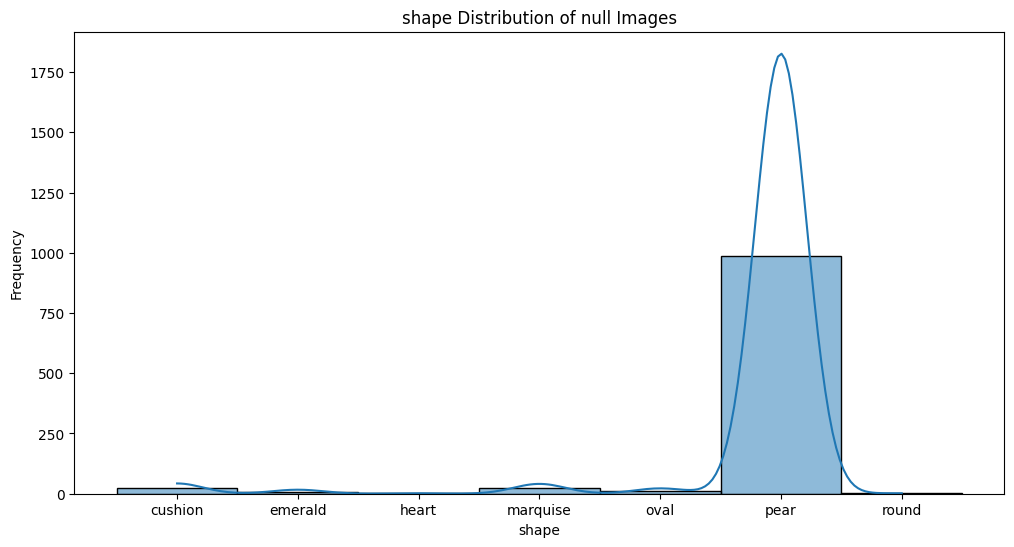

In [9]:
import seaborn as sns

# Plot shape distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_with_nulls['shape'], bins=30, kde=True)
plt.title('shape Distribution of null Images')
plt.xlabel('shape')
plt.ylabel('Frequency')
plt.show()

In [10]:
value_counts = df_with_nulls['shape'].value_counts()

print(value_counts)

shape
pear        985
cushion      23
marquise     22
oval         12
emerald       9
heart         1
round         1
Name: count, dtype: int64


as we can see most of the null values belong to the pear shape.

In [11]:
value_counts = dataframe['shape'].value_counts()

print(value_counts)

shape
round       21032
oval         6492
cushion      5341
pear         4338
princess     3949
heart        3756
emerald      3391
marquise      465
Name: count, dtype: int64


the amount of the null images belong to each shape is negligible except the pear shape which constitutes about 22% of the pear data.
we will need to consider if we can drop them

In [12]:
print(dataframe.describe())

              carat        length         width         depth
count  48764.000000  48764.000000  48764.000000  48764.000000
mean       0.946121      6.355401      5.626553      3.598057
std        0.564335      1.448487      1.075840      0.644895
min        0.500000      0.000000      0.000000      0.000000
25%        0.550000      5.180000      4.940000      3.160000
50%        0.760000      6.060000      5.380000      3.480000
75%        1.010000      7.150000      6.260000      3.970000
max        8.000000     16.060000     12.810000      7.960000


here we can see that the carat values are between 0.5-8 but the 50% is 0.76 which suggest most of the values are on the smoller size.

In [13]:
import matplotlib.pyplot as plt

image_paths = dataframe['path_to_img']

# Function to get image dimensions
def get_image_dimensions(image_paths):
    dimensions = []
    for img_path in image_paths:
        with Image.open(img_path) as img:
            width, height = img.size
            dimensions.append((width, height))
    return dimensions

# Get dimensions of all images
image_dimensions = get_image_dimensions(image_paths)

# Convert to a DataFrame for easier visualization
df_dimensions = pd.DataFrame(image_dimensions, columns=['Width', 'Height'])

In [14]:
column_names = dataframe.columns.tolist()
column_names.remove('path_to_img')

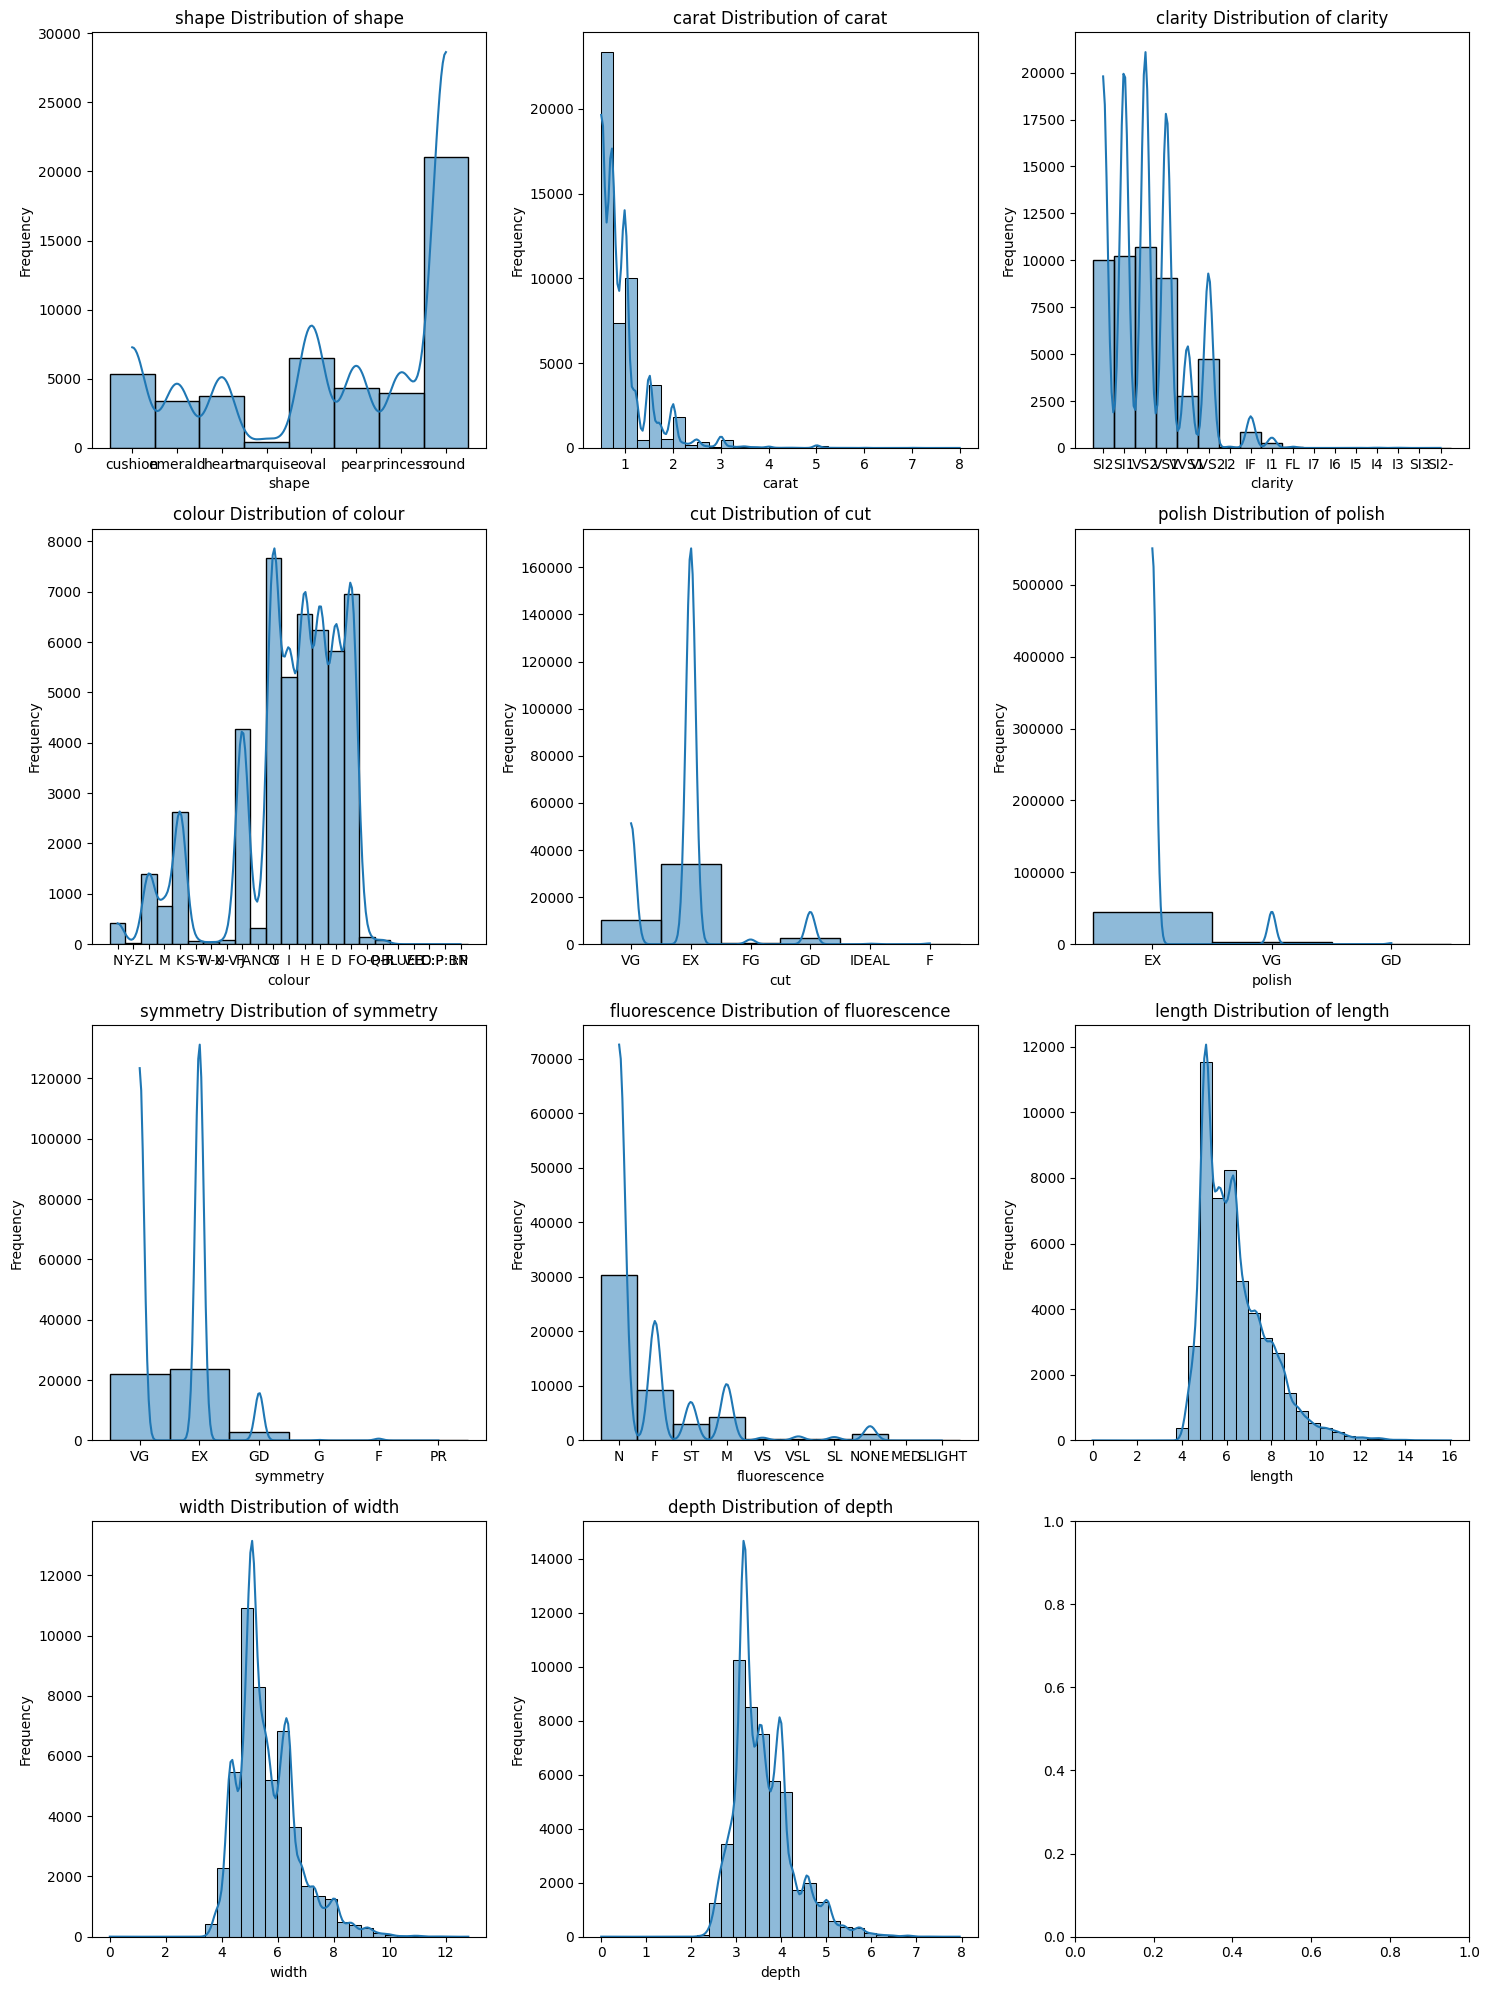

In [15]:
num_labels = len(column_names)

# Calculate the number of rows and columns for the subplots grid
n_cols = 3  
n_rows = int(num_labels/n_cols)+1  

# Create subplots 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Plot distributions
for i, label in enumerate(column_names):
    label_data = dataframe[label]
    sns.histplot(label_data, bins=30, kde=True, ax=axes[int(i/n_cols), i%n_cols])
    axes[int(i/n_cols), i%n_cols].set_title(f'{label} Distribution of {label}')
    axes[int(i/n_cols), i%n_cols].set_xlabel(label)
    axes[int(i/n_cols), i%n_cols].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

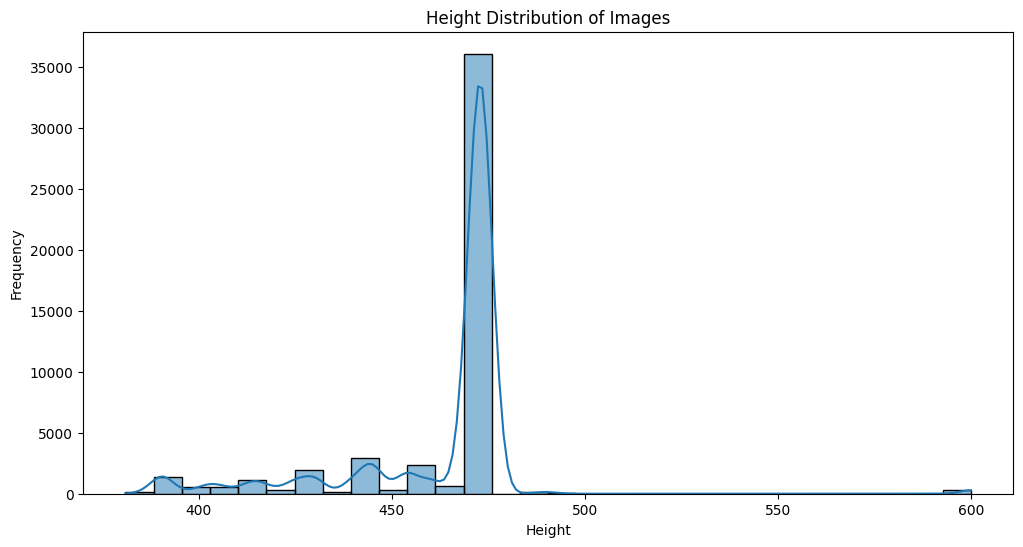

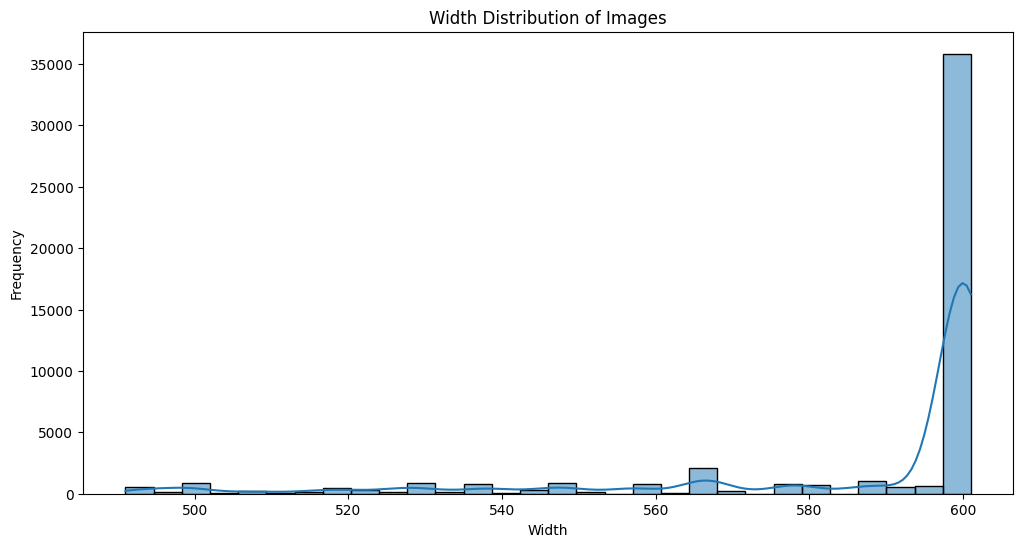

In [18]:
# Plot height distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_dimensions['Height'], bins=30, kde=True)
plt.title('Height Distribution of Images')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

# Plot width distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_dimensions['Width'], bins=30, kde=True)
plt.title('Width Distribution of Images')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.show()

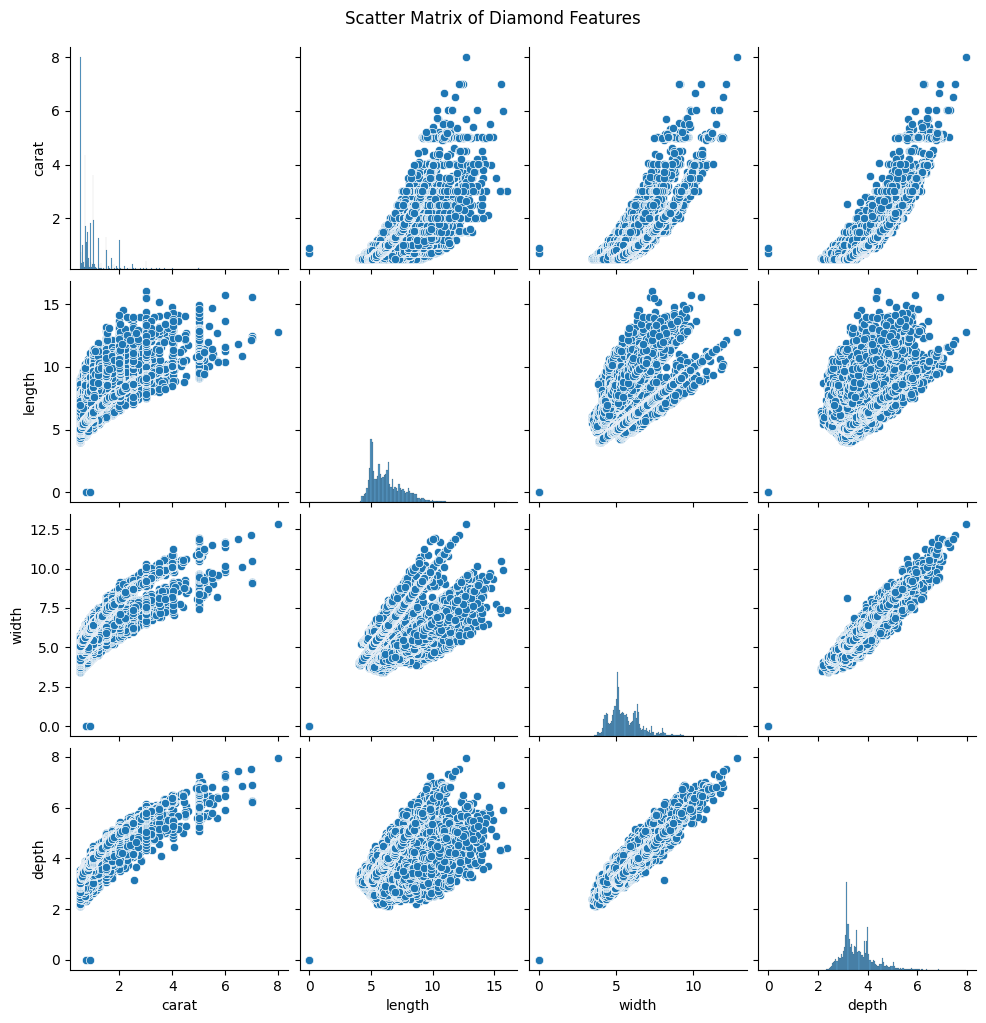

In [19]:
# Selecting relevant columns for the scatter matrix
features = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

# Create a scatter matrix
sns.pairplot(dataframe[column_names])
plt.suptitle('Scatter Matrix of Diamond Features', y=1.02)
plt.show()

Resizing and Normalization
Data Augmentation and Normalization: I used a series of image transformations from torchvision.transforms to preprocess the images. These transformations include resizing, converting to tensor, and normalizing the pixel values preparing the images for the CNN

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Handle the dataset images , prepare them for the model
The LabelEncoder from sklearn.preprocessing convert categorical string labels into numerical values. This is a preprocessing technique that converts categorical data into a form that can be provided to machine learning algorithms.
since the CNN expect to receive numerical values

In [21]:
class DiamondDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(os.path.join(root_dir, csv_file))
        self.root_dir = root_dir
        self.transform = transform
        
        # Initialize LabelEncoders for categorical labels
        self.label_encoders = {}
        for col in ['shape', 'clarity', 'colour', 'symmetry', 'fluorescence']:
            le = LabelEncoder()
            self.df[col] = le.fit_transform(self.df[col])
            self.label_encoders[col] = le

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['path_to_img']
        image = Image.open(image_path).convert('RGB') 
        labels = {
            'shape': self.df.iloc[idx]['shape'],
            'clarity': self.df.iloc[idx]['clarity'],
            'colour': self.df.iloc[idx]['colour'],
            'symmetry': self.df.iloc[idx]['symmetry'],
            'fluorescence': self.df.iloc[idx]['fluorescence'],
            'length': self.df.iloc[idx]['length'],
            'width': self.df.iloc[idx]['width'],
            'depth': self.df.iloc[idx]['depth']
        }
        if self.transform:
            image = self.transform(image)
        return image, labels

In [22]:
dataset = DiamondDataset(csv_file='diamond_data.csv', root_dir='web_scraped', transform=transform)

dividing the dataset to training set and validation set

In [23]:
# Uncomment and use the original lines for splitting the full dataset:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

defining the model to use pre trained resnet18 CNN. 
I used a pre-trained ResNet-18 model from torchvision.models as the base model. ResNet-18 is a type of convolutional neural network (CNN) that is particularly effective for image classification tasks due to its residual learning framework.

In [24]:
class DiamondMultiOutputModel(nn.Module):
    def __init__(self, num_classes_dict):
        super().__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        self.output_heads = nn.ModuleDict({
            task: nn.Sequential(
                nn.Flatten(), 
                nn.Linear(num_ftrs, 128),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(128, num_classes)
            ) for task, num_classes in num_classes_dict.items()
        })

    def forward(self, x):
        features = self.base_model(x)
        return {task: head(features) for task, head in self.output_heads.items()}

Multi-Output Neural Network: I modified the ResNet-18 model to create a multi-output model by replacing its fully connected layer with multiple task-specific output heads. Each output head is a small neural network responsible for predicting a specific attribute of the diamond.

In [25]:
num_classes_dict = {
    'shape': len(dataset.df['shape'].unique()),
    'clarity': len(dataset.df['clarity'].unique()),
    'colour': len(dataset.df['colour'].unique()),
    'symmetry': len(dataset.df['symmetry'].unique()),
    'fluorescence': len(dataset.df['fluorescence'].unique()),
    'length': 1,  
    'width': 1,   
    'depth': 1    
}

criterion_dict = {
    'shape': nn.CrossEntropyLoss(),
    'clarity': nn.CrossEntropyLoss(),
    'colour': nn.CrossEntropyLoss(),
    'symmetry': nn.CrossEntropyLoss(),
    'fluorescence': nn.CrossEntropyLoss(),
    'length': nn.MSELoss(),
    'width': nn.MSELoss(),
    'depth': nn.MSELoss()
}

allocating resorces for the model for the training, either CPU or GPU

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

creating the model and setting an optimizer to assist with the gradient dicent problem
Adam Optimizer: I used the Adam optimizer (torch.optim.Adam) to train the neural network. Adam is an adaptive learning rate optimization algorithm that is widely used in training deep learning models because it combines the benefits of two other extensions of stochastic gradient descent (SGD), specifically AdaGrad and RMSProp.

In [28]:
model = DiamondMultiOutputModel(num_classes_dict)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
# Initialize lists to track losses and accuracies
train_losses = []
val_losses = []
train_accuracies = {task: [] for task in num_classes_dict.keys()}
val_accuracies = {task: [] for task in num_classes_dict.keys()}
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

the actual training, 10 epochs devided to batch since the dataset is large

In [30]:
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_preds = {task: 0 for task in num_classes_dict.keys()}
    total_preds = 0

    # Use tqdm for training loop progress bar
    train_loop = tqdm(train_loader, desc=f'Epoch [{epoch+1}/10] (Training)')
    for batch_idx, (images, labels) in enumerate(train_loop):
        images = images.to(device)
        labels = {k: v.clone().detach().to(device, dtype=torch.long) for k, v in labels.items()}

        optimizer.zero_grad()
        outputs = model(images)

        # Calculate loss for each task
        loss = sum([criterion_dict[task](
            outputs[task], 
            labels[task].float().unsqueeze(1) if task in ['length', 'width', 'depth'] else labels[task]
        ) for task in outputs])

        loss.backward()
        optimizer.step()

        # Update running loss for display in tqdm
        running_loss += loss.item()
        train_loop.set_postfix(loss=running_loss/len(train_loader))
        
        # Calculate accuracy
        for task in outputs.keys():
            if task in ['length', 'width', 'depth']:
                continue  # Skip regression tasks for accuracy calculation
            correct_preds[task] += calculate_accuracy(outputs[task], labels[task])
        total_preds += len(images)
    train_losses.append(running_loss/len(train_loader))
    for task in correct_preds.keys():
        train_accuracies[task].append(correct_preds[task] / total_preds)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_preds = {task: 0 for task in num_classes_dict.keys()}
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f'Epoch [{epoch+1}/10] (Validation)'):
            images = images.to(device)
            labels = {k: v.clone().detach().to(device, dtype=torch.long) for k, v in labels.items()}
            outputs = model(images)
            val_loss += sum([criterion_dict[task](outputs[task], labels[task].float().unsqueeze(1) if task in ['length', 'width', 'depth'] else labels[task]) for task in outputs]).item()
            # Calculate accuracy
            for task in outputs.keys():
                if task in ['length', 'width', 'depth']:
                    continue  # Skip regression tasks for accuracy calculation
                correct_preds[task] += calculate_accuracy(outputs[task], labels[task])
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    for task in correct_preds.keys():
        val_accuracies[task].append(correct_preds[task] / len(val_loader))
        
    print(f'Epoch [{epoch+1}/10], Val Loss: {val_loss:.4f}')

torch.save(model.state_dict(), 'diamond_model.pth')

Epoch [1/10] (Validation): 100%|█████████████████████████████████████████████████████| 305/305 [03:59<00:00,  1.27it/s]


Epoch [1/10], Val Loss: 8.1915


Epoch [2/10] (Validation): 100%|█████████████████████████████████████████████████████| 305/305 [02:58<00:00,  1.71it/s]


Epoch [2/10], Val Loss: 5.9327


Epoch [3/10] (Validation): 100%|█████████████████████████████████████████████████████| 305/305 [02:58<00:00,  1.71it/s]


Epoch [3/10], Val Loss: 5.8295


Epoch [4/10] (Validation): 100%|█████████████████████████████████████████████████████| 305/305 [03:03<00:00,  1.67it/s]


Epoch [4/10], Val Loss: 5.6078


Epoch [5/10] (Validation): 100%|█████████████████████████████████████████████████████| 305/305 [02:58<00:00,  1.71it/s]


Epoch [5/10], Val Loss: 5.3825


Epoch [6/10] (Validation): 100%|█████████████████████████████████████████████████████| 305/305 [02:58<00:00,  1.70it/s]


Epoch [6/10], Val Loss: 6.6514


Epoch [7/10] (Validation): 100%|█████████████████████████████████████████████████████| 305/305 [02:58<00:00,  1.71it/s]


Epoch [7/10], Val Loss: 5.6721


Epoch [8/10] (Validation): 100%|█████████████████████████████████████████████████████| 305/305 [02:58<00:00,  1.71it/s]


Epoch [8/10], Val Loss: 5.4380


Epoch [9/10] (Validation): 100%|█████████████████████████████████████████████████████| 305/305 [03:58<00:00,  1.28it/s]


Epoch [9/10], Val Loss: 5.2782


Epoch [10/10] (Validation): 100%|████████████████████████████████████████████████████| 305/305 [02:56<00:00,  1.73it/s]

Epoch [10/10], Val Loss: 7.3091


I assess the model perfomance by the loss and accuracy metrics

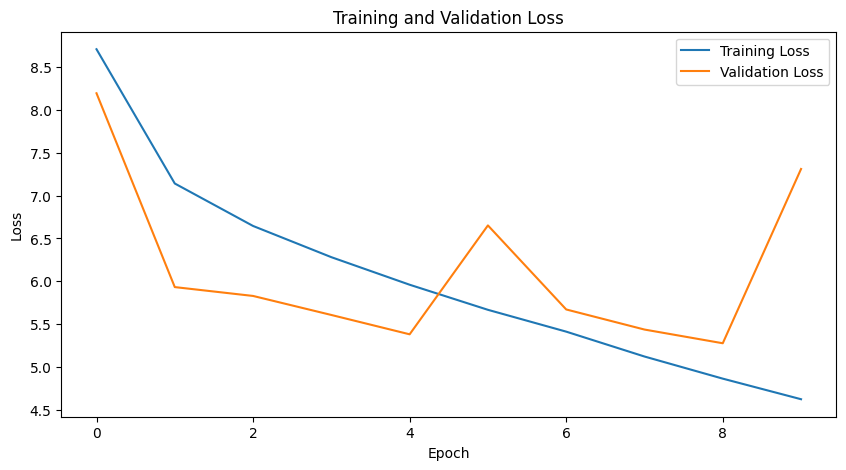

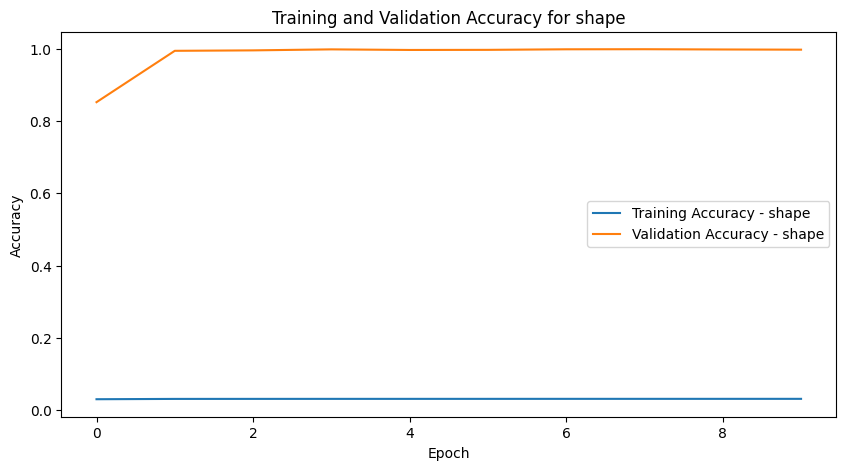

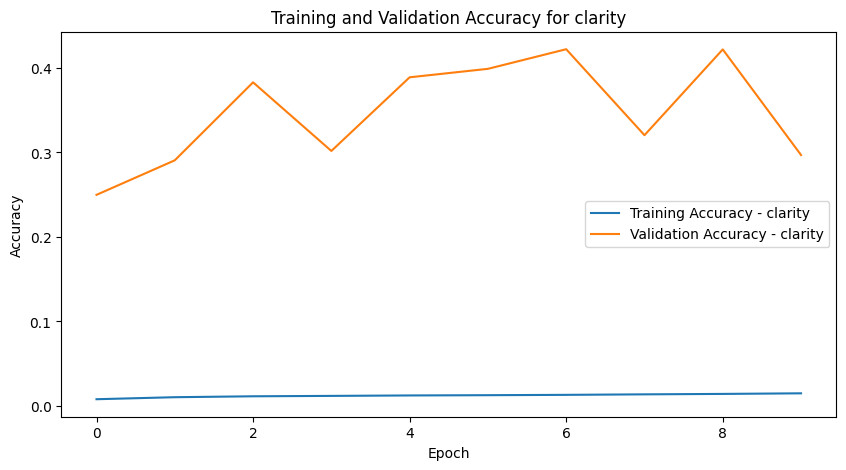

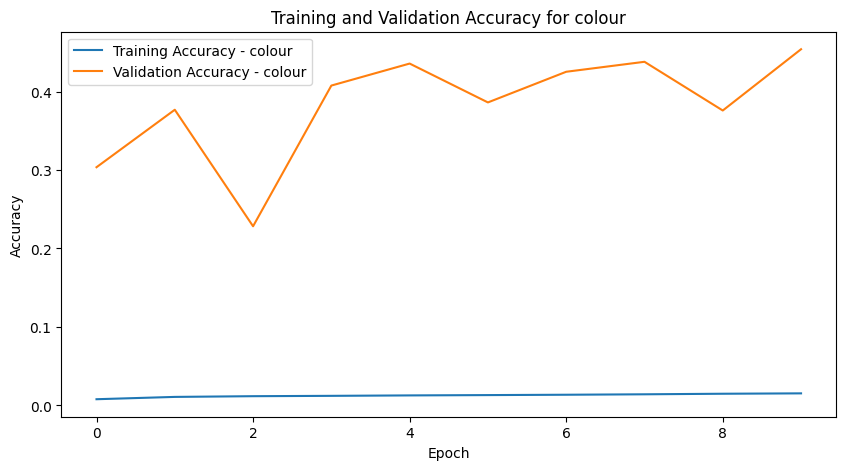

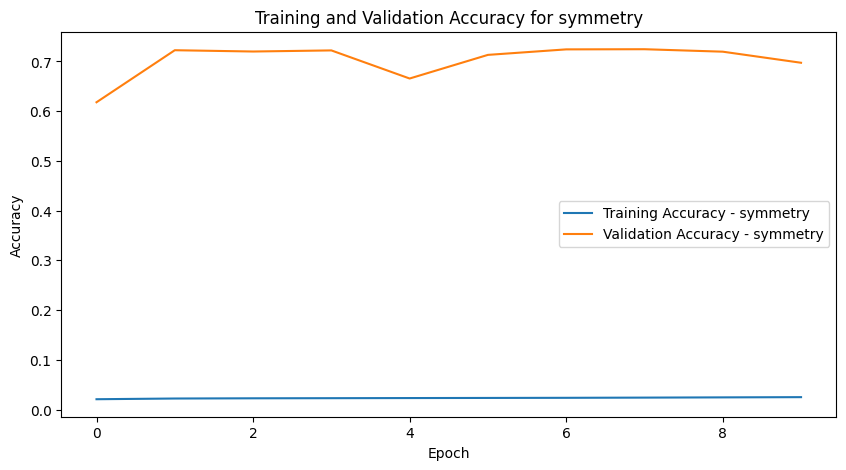

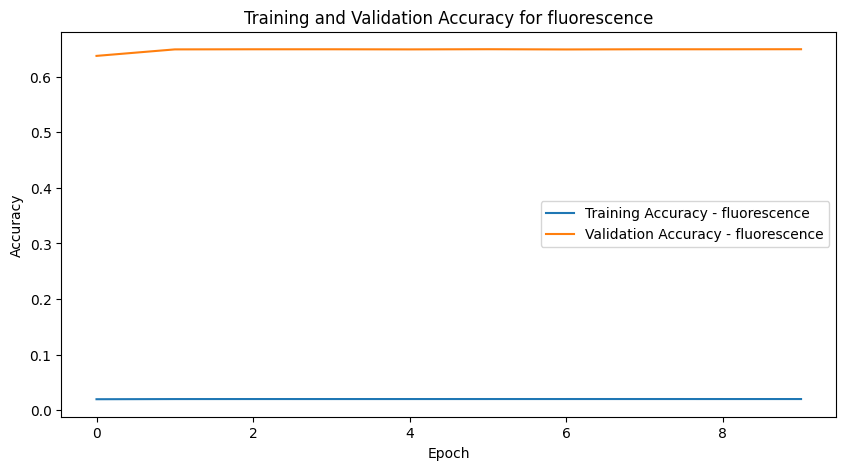

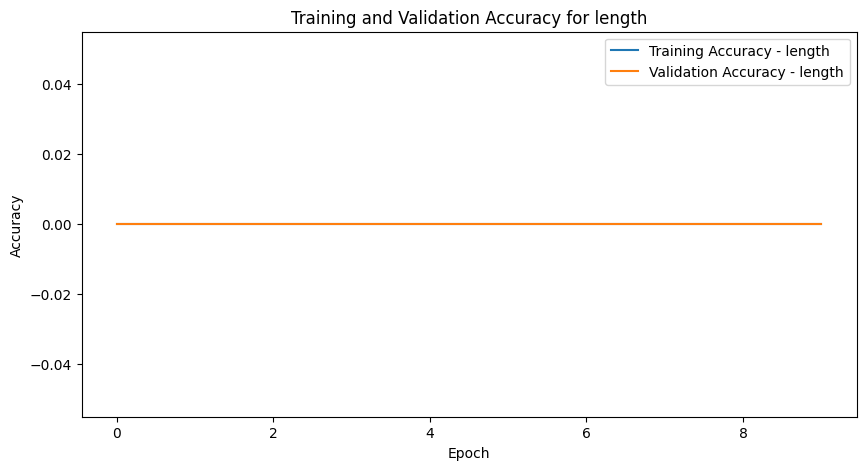

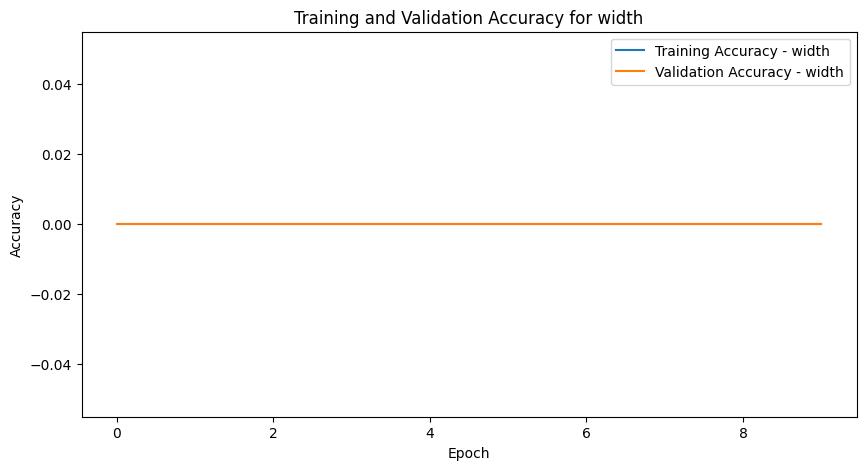

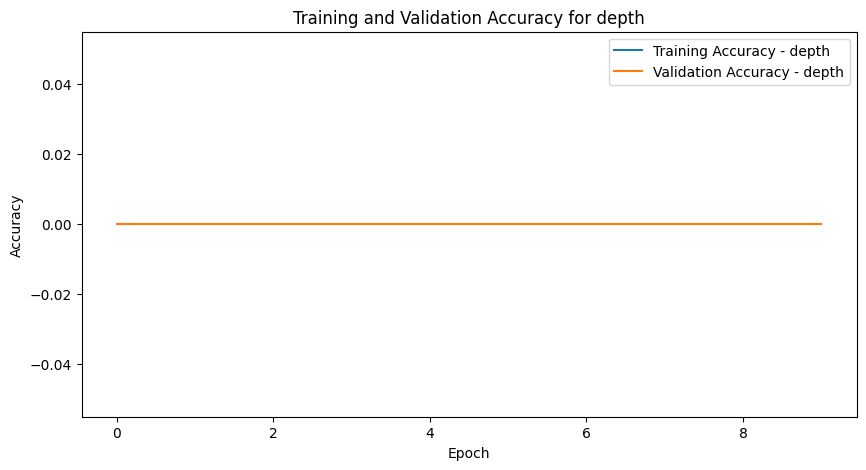

In [31]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the accuracies for each task
for task in train_accuracies.keys():
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies[task], label=f'Training Accuracy - {task}')
    plt.plot(val_accuracies[task], label=f'Validation Accuracy - {task}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy for {task}')
    plt.legend()
    plt.show()

as we can see, there is good decent of the loss parameter but the other scales are far from the validation.

In [32]:
from sklearn.calibration import LabelEncoder
import torch.nn.functional as F  

# Load the trained model
model_path = 'diamond_model.pth'

# Load the dataset (only to get unique values for label encoding)
dataset = DiamondDataset(csv_file='diamond_data.csv', root_dir='web_scraped', transform=None)

# Calculate num_classes_dict dynamically (same as in train.py)
num_classes_dict = {
    'shape': len(dataset.df['shape'].unique()),
    'clarity': len(dataset.df['clarity'].unique()),
    'colour': len(dataset.df['colour'].unique()),
    'symmetry': len(dataset.df['symmetry'].unique()),
    'fluorescence': len(dataset.df['fluorescence'].unique()),
    'length': 1,
    'width': 1,
    'depth': 1
}

In [ ]:
model = DiamondMultiOutputModel(num_classes_dict)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

In [34]:
# Preprocessing for new images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [35]:
# Function to decode predictions
def decode_predictions(outputs, dataset_csv_file='web_scraped/diamond_data.csv'):
    decoded_labels = {}
    df = pd.read_csv(dataset_csv_file)
    for task, output in outputs.items():
        if task in ['length', 'width', 'depth']:
            decoded_labels[task] = output.item()  # Continuous value
        else:
            probabilities = F.softmax(output, dim=1) 
            top_prob, top_idx = torch.topk(probabilities, 1)
            predicted_label = list(df[task].unique())[top_idx.item()]
            probability_percent = round(top_prob.item() * 100, 2)  # Use round() function
            decoded_labels[task] = (predicted_label, probability_percent)
    return decoded_labels

and a good solution is a successful recognition of a diamond, and its features

In [36]:
image_path = "web_scraped/emerald/214125-54.jpg"

# Load and preprocess the image
image = Image.open(image_path).convert('RGB')  # Ensure RGB format
image = transform(image).unsqueeze(0) 

# Make prediction
with torch.no_grad():  # No gradients needed for inference
    outputs = model(image)

# Decode predictions
predicted_labels = decode_predictions(outputs)

# Print the predicted labels
print("Predicted Diamond Attributes:")
for attribute, value in predicted_labels.items():
    if isinstance(value, tuple):  # Categorical attribute with probability
        print(f"{attribute.capitalize()}: {value[0]} (Probability: {value[1]}%)")
    else:  # Continuous attribute
        print(f"{attribute.capitalize()}: {value}")


Predicted Diamond Attributes:
Shape: emerald (Probability: 100.0%)
Clarity: FL (Probability: 76.87%)
Colour: J (Probability: 46.81%)
Symmetry: nan (Probability: 54.46%)
Fluorescence: M (Probability: 80.44%)
Length: 6.697113513946533
Width: 4.794760704040527
Depth: 2.930776357650757


Actual Diamond Attributes:
Shape: emerald 
Clarity: SI2
Colour: H 
Symmetry: EX
Fluorescence: N 
Length: 7.74
Width: 5.71
Depth: 3.91

as we can see there is a lack of match between the prediction and the actual data.

I intend to improve the data augmentation by adding more techniques, and adding Confusion Matrix for classification tasks and Regression Plots for regression tasks.
and i want to Implement cross-validation with a different data subsets.
i should experiment with different hyperparameters (learning rate, batch size, number of epochs)